In [4]:
import numpy as np
import torch

## Wyzwanie
Perceptron dla obecnych sieci neuronowych jest jak Australopitek dla Homo sapiens - możemy się śmiać, że sieć kiedyś była taka prymitywna, ale bez zrozumienia niej - nie zrozumiemy całego skomplikowania nowoczesnych architektur. Twoim zadaniem będzie implementacja perceptronu, a także jego nauka od zera. Wyniki zweryfikujesz implementując na końcu taką samą sieć w [Pytorchu](https://docs.pytorch.org/docs/stable/index.html).

## Jak zrobić zadanie
0. Dane są te same co w poprzednim zadaniu - [Bank Marketing](https://archive.ics.uci.edu/dataset/222/bank+marketing)
1. Wykorzystaj wiedzę z poprzedniego notebooka (jak i kod, jeśli się da) do przygotowania danych. Pamiętaj o podziale na zbiory train, val i test. Przeskaluj dane używając StandardScaler lub innych, oczywiście unikając wycieku danych.
2. Możecie ograniczyć się do dwóch cech wejściowych - wybranych wedle uznania - do celów zadania (np. dwie cechy łatwiej jest zwizualizować)
3. Niżej są podane instrukcje (symbol ⚡ oznacza, że coś trzeba zaimplementować) - najlepiej rób je sekwencyjnie.

przydatne materiały:
* [deep_learning_60min_blitz](https://docs.pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html),
* [zrozumienie under/overfitting](https://mlu-explain.github.io/bias-variance/),
* [SUPER tutorial(e)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html),
* [Mathematics of neural networks in machine learning](https://en.wikipedia.org/wiki/Mathematics_of_neural_networks_in_machine_learning),
* [Pozycja 53 -> rozdziały 2 (fenomenalny),11](https://docs.google.com/spreadsheets/d/1UnjOh5TYgNiFBw9jsM6mJrp68uEdzeW3iIi6Ew0xfgQ/edit?gid=0#gid=0),
* [Optymizatory & uczenie paczkami](https://arxiv.org/pdf/1609.04747)


### Problemy w uczeniu maszynowym

Przypomnijmy sobie jeszcze czym się różni zadanie **klasyfikacji** od **regresji**. Jak już zapewne wiesz, nasze dane można podzielić na zbiór cech (X) oraz na zbiór zmiennych docelowych (y). Ten drugi może kodować informacje o tym, jaka jest klasa przynależności (np. *chory ∈ {true, false}*, *kolor ∈ {zielony, niebieski, czerwony}*), lub jaka jest wartość pewnej cechy (np. *temperatura ∈ ℜ*, *punkty z egzaminu* ∈ 𝒵). W zadaniu klasyfikacji mamy do czynienia z kategoriami, które są dyskretne, a w zadaniu regresji zmienne docelowe są zwykle ciągłe. Dlaczego to istotne? W trakcie pracy nad notebookiem pewnie zdasz sobie sprawę, że nie można do problemu klasyfikacji użyć straty najmniejszych kwadratów - co byłoby odpowiednie w problemie regresji.

In [5]:
!pip install ucimlrepo

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


bank_marketing = fetch_ucirepo(id=222)
X = bank_marketing.data.features
y = bank_marketing.data.targets

bank_marketing_df = pd.concat([X, y], axis=1)


bank_marketing_df = bank_marketing_df.drop(['duration', 'day_of_week', 'education', 'contact'], axis=1)

bank_marketing_df['poutcome'] = bank_marketing_df['poutcome'].fillna('unknown')

bank_marketing_df = bank_marketing_df.convert_dtypes()


kolumny_binarne = ['default', 'y']
bank_marketing_df[kolumny_binarne] = bank_marketing_df[kolumny_binarne].replace({'yes': '1', 'no': '0'})
bank_marketing_df[kolumny_binarne] = bank_marketing_df[kolumny_binarne].astype('int64')

bank_marketing_df['is_single'] = bank_marketing_df['marital'].apply(lambda x: 1 if x in ['single', 'divorced'] else 0)
bank_marketing_df = bank_marketing_df.drop('marital', axis=1)

bank_marketing_df['loan'] = bank_marketing_df['loan'].replace({'yes': '1', 'no': '0'}).astype('int64')
bank_marketing_df['housing'] = bank_marketing_df['housing'].replace({'yes': '1', 'no': '0'}).astype('int64')
bank_marketing_df['hasLoan'] = bank_marketing_df.apply(lambda x: 1 if x['loan'] > 0 or x['housing'] > 0 else 0, axis=1)
bank_marketing_df = bank_marketing_df.drop(['loan', 'housing'], axis=1)


monthMap= {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
    'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
    'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
bank_marketing_df['month'] = bank_marketing_df['month'].map(monthMap)

mapowanie_poutcome = {
    'failure': -1,
    'other': 0,
    'success': 1,
    'unknown': 0
}
bank_marketing_df['poutcome'] = bank_marketing_df['poutcome'].map(mapowanie_poutcome)
bank_marketing_df['poutcome'] = bank_marketing_df['poutcome'].astype(pd.Int64Dtype())

y_data = bank_marketing_df['y'].astype(int)
bank_marketing_df.drop('y', axis=1, inplace=True)
X_data = bank_marketing_df

X_temp, X_test, y_temp, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

X_train['beenContacted'] = X_train.apply(lambda x: 1 if x['pdays'] >= 0 or x['previous'] > 0 else 0, axis=1)
X_test['beenContacted'] = X_test.apply(lambda x: 1 if x['pdays'] >= 0 or x['previous'] > 0 else 0, axis=1)
X_val['beenContacted'] = X_val.apply(lambda x: 1 if x['pdays'] >= 0 or x['previous'] > 0 else 0, axis=1)



X_train = X_train.drop(['pdays', 'previous'], axis=1)
X_test = X_test.drop(['pdays', 'previous'], axis=1)
X_val = X_val.drop(['pdays', 'previous'], axis=1)



dostepne_zawody = X['job'].dropna().unique()
X_train['job'] = X_train['job'].apply(
    lambda x: np.random.choice(dostepne_zawody) if pd.isna(x) else x
)
X_test['job'] = X_test['job'].apply(
    lambda x: np.random.choice(dostepne_zawody) if pd.isna(x) else x
)
X_val['job'] = X_val['job'].apply(
    lambda x: np.random.choice(dostepne_zawody) if pd.isna(x) else x
)


encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(X_train[['job']])

def apply_ohe_and_join(df, encoder_obj):
    job_encoded = encoder_obj.transform(df[['job']])
    feature_names = encoder_obj.get_feature_names_out(['job'])
    job_df = pd.DataFrame(job_encoded, columns=feature_names, index=df.index)
    df = pd.concat([df.drop('job', axis=1), job_df], axis=1)
    return df

X_train = apply_ohe_and_join(X_train, encoder)
X_test = apply_ohe_and_join(X_test, encoder)
X_val = apply_ohe_and_join(X_val, encoder)


X_train = X_train.astype(int)
X_test = X_test.astype(int)
X_val = X_val.astype(int)


X_train=X_train[['hasLoan','balance']]
X_test=X_test[['hasLoan','balance']]
X_val=X_val[['hasLoan','balance']]

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)


In [10]:
print(X_train.columns)

Index(['hasLoan', 'balance'], dtype='object')


In [11]:
X_train.head()

,hasLoan,balance
20326,0.782093,-0.091696
24301,0.782093,-0.449095
38618,0.782093,0.626028
18909,-1.278621,0.333935
23081,-1.278621,0.597111


Wziąłem 2 najważniejsze zbiory według SHAP z EDA, może nie najlepsze dla tego zadania, ale zobaczymy

## 1. Perceptron*
Wejdziemy w trochę matematyki (serio, matma jest niezbędna jeśli chcesz być Pro AI engineer'em). Najprostszy perceptron opisany jest wzorem

$$A = σ(𝑤^TX + b) = σ(Z) = (a_1, ..., a_{m-1})$$
gdzie


*   σ to funkcja aktywacji
*   $X$ to macierz cech, wymiaru $k \times m$ ($=$ liczba cech $\times$ liczba próbek)
*   𝑤 to macierz wag z $k$ wartościami (wyuczalne parametry)
*   b to skalar, zwany *biasem* (wyuczalny parametr)
*   $A$ to wyjściowy wektor o długości $m$

Popularne funkcje aktywacji:
- Relu: $f(Z) = max(Z, 0)$
- Sigmoid: $f(Z) = \frac{1}{1 + e^{-Z}}$

Jednak w tym zadaniu poprawna będzie tylko jedna - musisz sam(a) wybrać która to będzie i dlaczego. (Hint: zastanów się, *co oznacza wyjście sieci*, i dlaczego ta "niepoprawna" funkcja aktywacji będzie psuła sieć)

*W rzeczywistości nie będzie to [stricte perceptron](https://pl.wikipedia.org/wiki/Perceptron), ponieważ nie będziemy implementować skokowej funkcji straty.

Używamy Sigmoida, bo da nam odp z przedziału (0,1). ReLu nam da jakąś liczbę, która nie zawsze będzie określać prawdopodobieństwo.

### ⚡ Zaimplementuj tutaj perceptron

In [12]:
class Perceptron:

  def __init__(self):
    pass

  def forward(self, X: np.ndarray, W: np.ndarray, b: float): #przekazuje wyliczone wagi oraz macierz X i b
    Z = np.dot(X,W) + b
    A=(1/(1+np.exp(-Z)))
    return A

### Przejście w przód i w tył

Następnym zadaniem jest wyuczenie naszych macierzy. Prawdopodobnie twoje wartości są losowe (mam nadzieję, że macierz nie jest wypełniona zerami), przez co i sieć daje losowe wyniki. To, co możemy wydzielić jako atomową operację w procesie uczenia sieci składa się z kroków:
1. Forward propagation (przejście w przód) - wymnożenie wejściowych cech przez wagi sieci
2. Loss (obliczanie straty) - obliczamy jaki jest błąd popełniany przez sieć
3. Backward propagation (przejście w tył) - propagacja gradientu i **aktualizacja** wag sieci

Proces uczenia zachodzi w N epokach.

Pytanie filozoficzne: czy strata może być równa zero? czy możemy wyczyć idealną sieć? Jak sądzisz, w jakich warunkach tak może być? (warto na takie przemyślenie poświęcić >=30 sekund).

Matematycznie ma to taką postać:
* Fp: $A = σ(𝑤^TX + b) = σ(Z)$ (to było już)
* Loss: L = $\frac{1}{M} g(A, Gt)$, gdzie $Gt$ to prawdziwe, poprawne wartości, a $g$ to odpowiednia dla problemu funkcja straty. Dzielimy przez liczbę próbek, bo chcemy uzyskać średnią wartość błędu,
* Bp: niestety nie zachodzi w jednym kroku. Rozpiszmy to

$$L = \frac{1}{M} g(A, Gt)$$  -> mamy nasz wyliczony loss (musimy mieć wartość skalarną, dlatego uśredniamy startę)
$$\frac{∂L}{∂𝑤} = ? $$ -> to chcemy wyliczyć (zaraz, zaraz powiemy po co)
$$ \frac{∂L}{∂𝑤} = \frac{∂L}{∂A} \frac{∂A}{∂Z} \frac{∂Z}{∂w}$$ -> to wynika z [twierdzenia łańcuchowego](https://en.wikipedia.org/wiki/Chain_rule)

Jaki mamy deal z tego? Otóż będziemy obliczać pochodne zmiany funkcji starty względem parametrów sieci tak, by je dostosowywać w kierunku zmniejszenia się tej straty (spadek wzdłuż gradientu [link text](https://en.wikipedia.org/wiki/Gradient_descent)). Aktualizacja wag sieci, w epoce n, ma postać:

$$𝑤^{n + 1} = 𝑤^{n} - \alpha \frac{∂L}{∂𝑤}$$

gdzie $\alpha$ jest hiperparameterem (czyli taką wartością, która jest ustalana z góry, przed uruchomieniem treningu), zwykle o wartościach $0.01$, czy $0.001$.
 Decyduje ona o szybkości treningu.

 Twoim zadaniem jest teraz ⚡ implementacja klasy do trenowania, dla której docelowo chcemy tylko wywołać funkcję *train*, a w środku ma zachodzić cała magia. Funkcja *predict* ma służyć do predykcji kategorii dla próbek testowych.

In [13]:
from collections import defaultdict
import matplotlib.pyplot as plt

In [14]:
class Trainer:

  def __init__(self, perceptron: Perceptron, n_epochs: int, batch_size: int, a: float):
    self.perceptron = perceptron
    self.n_epochs = n_epochs
    self.a=a
    self.W=None
    self.b=0.0
    self.batch_size=batch_size
    self.Bp=None
    self.history = defaultdict(list)

  def loss(self, A: np.array, y: np.ndarray): # oblicza stratę między wyjściem sieci a ground truth
    M= A.shape[0]
    L = (-1/M)*np.sum(y*np.log(A)+(1-y)*np.log(1-A))
    return L

  def backward(self, X: np.ndarray, A: np.array, y: np.ndarray): # dołóż więcej argumentów wejściowych, jeśli są potrzebne
    M=A.shape[0]
    Bp=X.T@(A-y)*(1/M)
    return Bp

  def update_weights(self): # dołóż więcej argumentów wejściowych, jeśli są potrzebne
    self.W=self.W-self.a*self.Bp
    return None

  def train(self, X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray):
    X_train = np.array(X_train)
    y_train = np.array(y_train).reshape(-1, 1)
    X_val = np.array(X_val)
    y_val = np.array(y_val).reshape(-1, 1)

    indices = np.arange(X_train.shape[0])
    self.W = np.random.uniform(-0.01, 0.01, (X_train.shape[1], 1))
    m = X_train.shape[0]

    for i in range(self.n_epochs):
      np.random.shuffle(indices)

      for f in range(0, m, self.batch_size):
        batch_idx = indices[f : f + self.batch_size]

        X_bat = X_train[batch_idx]
        Y_bat = y_train[batch_idx]

        A = self.perceptron.forward(X_bat, self.W, self.b)
        self.Bp = self.backward(X_bat, A, Y_bat)
        self.update_weights()

      A_train = self.perceptron.forward(X_train, self.W, self.b)
      A_loss = self.loss(A_train, y_train)
      A_val = self.perceptron.forward(X_val, self.W, self.b)
      A_val_loss = self.loss(A_val, y_val)

      self.history['train_loss'].append(A_loss)
      self.history['val_loss'].append(A_val_loss)
      self.history['train_acc'].append(np.mean(np.round(A_train) == y_train))
      self.history['val_acc'].append(np.mean(np.round(A_val) == y_val))


    self.plot_history()
    return None

  def predict(self, X: np.ndarray) -> np.ndarray: # funkcja na wykonanie inferencji
    A = self.perceptron.forward(X, self.W, self.b)
    return (A >= 0.5).astype(int)
  def plot_history(self):
      epochs = range(1, len(self.history['train_loss']) + 1)

      plt.figure(figsize=(12, 5))

      # Wykres Loss
      plt.subplot(1, 2, 1)
      plt.plot(epochs, self.history['train_loss'], label='Train Loss')
      plt.plot(epochs, self.history['val_loss'], label='Val Loss')
      plt.title('Training and Validation Loss')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.grid(True)

      # Wykres Accuracy
      plt.subplot(1, 2, 2)
      plt.plot(epochs, self.history['train_acc'], label='Train Acc')
      plt.plot(epochs, self.history['val_acc'], label='Val Acc')
      plt.title('Training and Validation Accuracy')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.grid(True)

      plt.tight_layout()
      plt.show()

## HINTS
Hint1: na kartce rozpisz sobie krok po kroku przejście w przód. Najlepiej użyj tej samej konwencji nazewniczej zmiennych, lub zdefiniuj zmienne pomocniczne. Rozwiń jaki będzie konkretny wzór na pochodne: $\frac{∂L}{∂A}$, $\frac{∂A}{∂z}$ i  $\frac{∂z}{∂w}$. Jak już przez to przebrniesz, to przepisanie tego do Pythona powinno być bezbolesne i skuteczne.

Hint2: Funkcje straty, które powinieneś/powinnaś rozważać to [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) lub [BCE](https://www.geeksforgeeks.org/deep-learning/binary-cross-entropy-log-loss-for-binary-classification/). Jeśli rozpisanie gradientu jest dla ciebie nie do przejścia, to posłuż się "gotowcem", ale nadal spróbuj samodzielnie przepisać na kod.

Hint3: do mnożenia macierzy w numpy używamy ```np.dot``` lub ```@```.

Hint4: początkowe wartości macierzy $𝑤$ mogą być zaincjalizowane losowymi wartościami z niewielkiego zakresu (np. $[-0.01, 0.01]$)

Hint5: wartości wejściowe powinny być ustandaryzowane (dla poprawy jakości spadku wzdłuż gradientu)

### Uczenie paczkami
Być może już zauważyłeś/łaś, że wymnażanie wielkiej macierzy $X$ w pojedynczym kroku jest problematyczne - jeśli nie w tym eksperymencie, to w następnym. Istnieją różne strategie do aktualizacji parametrów:
* batch gradient descent - aktualizacja parametrów odbywa się po przejściu wszystkich próbek przez sieć, a gradient jest uśredniany (to, co pewnie masz teraz)
* stochastic gradient descent - aktualizacja parametrów następuje po każdej pojedynczej próbce (podejście na drugim końcu spektrum)
* mini-batch stochastic gradient descent - podział wszystkich próbek na paczki o wielkości $M$, i aktualizacja gradientu po każdej paczce (podejście "po środku" dwóch poprzednich)

Zastanów się, które podejście jest odpowiednie i w funkcji *train* ⚡ doimplementuj odpowiedni podział (lub nie?) macierzy danych $X$.

Nic nie stoi na przeszkodzie, by udokumentować zachowanie sieci dla każdej strategii (możesz to zawrzeć w dalszej sekcji eksperymentów).


### Śledzenie przebiegu uczenia

W praktyce, sam spadek wzdłuż gradientu nie gwarantuje, że dostaniemy optymalne wagi sieci. W celu weryfikacji, czy nie doszło do **przeuczenia**, twoim ⚡ kolejnym krokiem będzie dodanie do klasy *Trainer* funkcji, które zapiszą, na końcu każdej epoki

 (a) istotne metryki w kontekście zadania,

(b) wartość straty

zarówno dla zbioru treningowego, jak i walidacyjnego - najlepiej w postaci wykresu. Na ich podstawie zdiagnozuj, czy model podlega **niedouczeniu / underfitting**, **przeuczeniu / overfitting**, a może jest względnie "dobry".  

### ⭐ Ekstra zadanie - optymizator
Spadek wzdłuż gradientu zawsze bierze pod uwagę tylko aktualne wartości gradientów, przez co może być podatny na gwałtowne zmiany. W celu wydajniejszego trenowania stosuje się [optymizatory](https://arxiv.org/pdf/1609.04747) typu *Momentum* czy *Adagrad* (choć w praktyce zwykle *Adam*). Zaimplementuj wybrany optimzator i porównaj, jak uczy się sieć z i bez, oraz jak zmieniają się wartości wag (np. możesz logować bezwzględną, uśrednioną wartość zmian wag).

### ⚡ Eksperymenty
Zbadaj skuteczność sieci oraz oceń, czy dobrze się generalizuje na podstawie krzywych uczenia. Dokładniej, zbadaj co najmniej **3 wartości współczynnika uczenia** i **3 wartości liczby epok**. Zapisz swoje obserwacje. Nie przejmuj się, jeśli po nieudanych próbach twoja sieć nie chce się uczyć - jeśli czujesz, że wiesz w czym leży błąd, to zapisz te obserwacje.

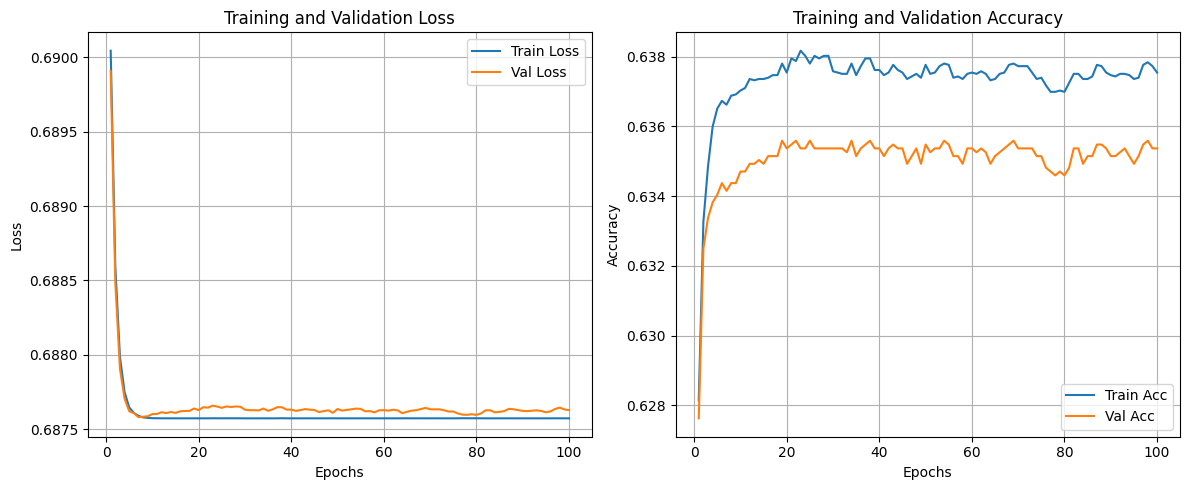

In [28]:
perceptron = Perceptron()
trainer = Trainer(perceptron, n_epochs=100, batch_size=16,a=0.001)
trainer.train(X_train, y_train, X_val, y_val)


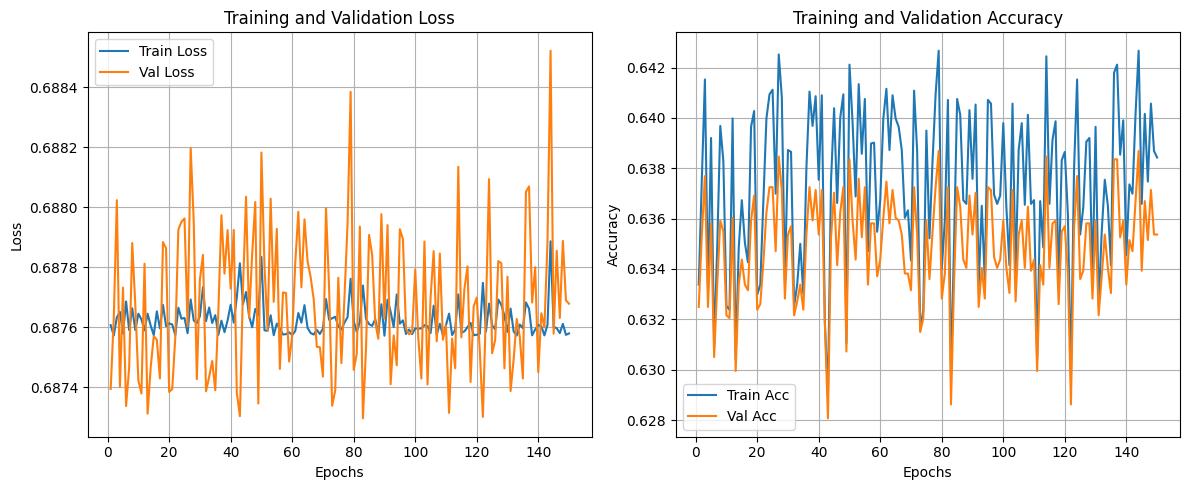

In [29]:
trainer1 = Trainer(perceptron, n_epochs=150, batch_size=16,a=0.01)
trainer1.train(X_train, y_train, X_val, y_val)


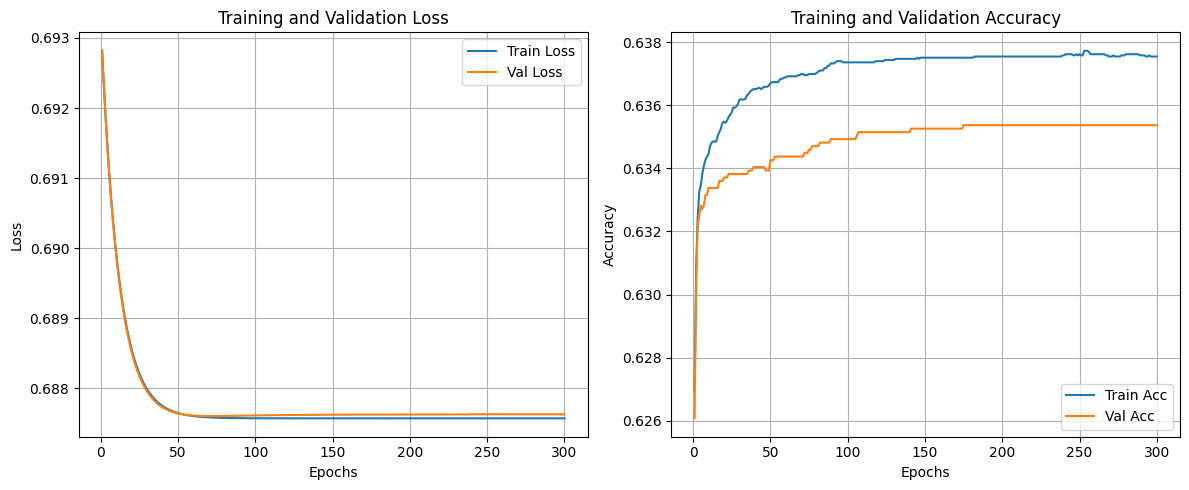

In [32]:
trainer3 = Trainer(perceptron, n_epochs=300, batch_size=16,a=0.0001)
trainer3.train(X_train, y_train, X_val, y_val)


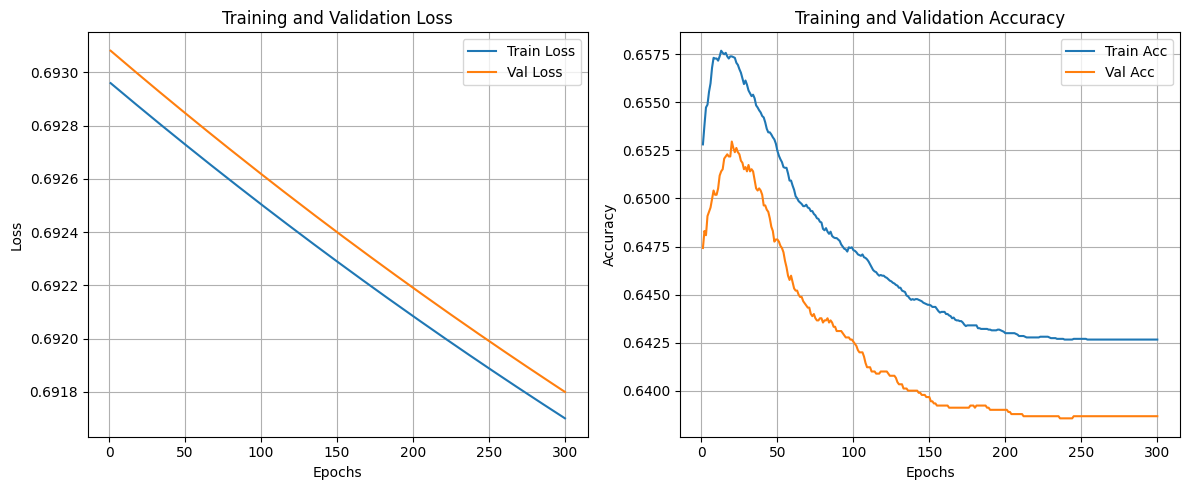

In [33]:
trainer2 = Trainer(perceptron, n_epochs=300, batch_size=16,a=0.000001)
trainer2.train(X_train, y_train, X_val, y_val)


Jak widać przy wyższym a model ma problemy z nauką, dopiero przy niższych wartościach widać moment, gdy wykresy są czytelne. Przy bardzo małym A widać overfitting, dane treningu i walidacji od siebie trochę odbiegają.

## 2. Implementacja sieci w pytorchu
Następnie ⚡ zaimplementujesz perceptron korzystając z biblioteki pytorch w celu weryfikacji wyników.

### Tensory
Są to struktury danych zbliżone do macierzy **np.array**, tyle, że mogą być przenoszone na karty graficzne, które są niezbędne do wyuczenia głębokich sieci. W następującej części zadania będziesz musiał(a) opanować pracę z tensorami i ich zamianę z i do tablicy NumPy.

In [19]:
data_list = [[2, 5], [3, 6],[4, 7]]
numpy_array = np.array(data_list) # tablica numpy utworzona z listy
data_tensor = torch.from_numpy(numpy_array) # tensor utworzony z tablicy numpy
print(data_tensor.shape) # kształt tensora
data_tensor

torch.Size([3, 2])


tensor([[2, 5],
        [3, 6],
        [4, 7]])

### Perceptron w torchu
Z wykorzystaniem biblioteki [torch.nn](https://docs.pytorch.org/docs/stable/nn.html) ⚡ zaimplementuj jednowarstwową sieć neuronową wraz z jej trenowaniem, z która porównasz swoją sieć zbudowaną w numpy. Przydatny może być tutorial [pytorch-nn](https://docs.pytorch.org/tutorials/beginner/pytorch_with_examples.html#learning-pytorch-with-examples). ⚡ Powtórz te same eksperymenty, które wykonane zostały dla twojego Perceptronu, oraz porównaj ze sobą wyniki. Zastanów się, skąd mogą wynikać różnice oraz dlaczego ostatecznie nie chcelibyśmy implementować sieci neuronowych w numpy 😅.


---


*Uwaga*: jeśli czujesz, że jest to dla ciebie zbyt proste, to skontruuj klasę wielowarstwowej sieci neuronowej do "prawdziwego" rozwiązania problemu (spróbuj wtedy wykorzystać (prawie) wszystkie kolumny).

*Uwaga do uwagi*: jeśli czujesz, że to nadal za mało, to przepisz sieć do frameworka [lightning](https://lightning.ai/docs/pytorch/stable/). Dodaj do tego logowanie w tensorboard.

In [20]:
import torch.nn as nn

In [21]:
class PerceptronTorch(torch.nn.Module):
  def __init__(self, dim: int):
    super().__init__()
    self.layer_size = nn.Linear(dim, 1)
    self.activation = nn.Sigmoid()

  def forward(self, A: torch.Tensor):
    return self.activation(self.layer_size(A))

In [22]:
class TrainerTorch:

  def __init__(self, perceptron: PerceptronTorch, n_epochs: int, batch_size:int, lr: float):
    self.perceptron = perceptron
    self.n_epochs = n_epochs
    self.history = defaultdict(list)
    self.batch_size = batch_size
    self.lr=lr

  def train(self, X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray):

    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)


    optimizer=torch.optim.SGD(self.perceptron.parameters(),lr=self.lr)
    criterion=nn.BCELoss() #tez uzywam BCE


    indices = np.arange(X_train.shape[0])
    self.W = np.random.uniform(-0.01, 0.01, (X_train.shape[1], 1))
    m = X_train.shape[0]

    for i in range(self.n_epochs):
      np.random.shuffle(indices)

      for f in range(0, m, self.batch_size):
        batch_idx = indices[f : f + self.batch_size]

        X_bat = X_train_t[batch_idx]
        Y_bat = y_train_t[batch_idx]
        optimizer.zero_grad()
        A=self.perceptron(X_bat)
        loss=criterion(A,Y_bat)
        loss.backward()
        optimizer.step()






      with torch.no_grad(): #zeby mi nie liczyl gradientow, gdy ja tylko chce dane zapisac
                A_train = self.perceptron(X_train_t)
                A_val = self.perceptron(X_val_t)

                train_l = criterion(A_train, y_train_t).item()
                val_l = criterion(A_val, y_val_t).item()

                train_acc = np.mean((A_train.numpy() >= 0.5) == y_train_t.numpy())
                val_acc = np.mean((A_val.numpy() >= 0.5) == y_val_t.numpy())

                self.history['train_loss'].append(train_l)
                self.history['val_loss'].append(val_l)
                self.history['train_acc'].append(train_acc)
                self.history['val_acc'].append(val_acc)

    self.plot_history()
    return None

  def predict(self, X: np.ndarray) -> np.ndarray: # funkcja na wykonanie inferencji
    X_t = torch.tensor(X, dtype=torch.float32)
    A=self.perceptron(X_t)
    return (A >= 0.5).astype(int)



  def plot_history(self):
      epochs = range(1, len(self.history['train_loss']) + 1)

      plt.figure(figsize=(12, 5))

      # Wykres Loss
      plt.subplot(1, 2, 1)
      plt.plot(epochs, self.history['train_loss'], label='Train Loss')
      plt.plot(epochs, self.history['val_loss'], label='Val Loss')
      plt.title('Training and Validation Loss')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.grid(True)

      # Wykres Accuracy
      plt.subplot(1, 2, 2)
      plt.plot(epochs, self.history['train_acc'], label='Train Acc')
      plt.plot(epochs, self.history['val_acc'], label='Val Acc')
      plt.title('Training and Validation Accuracy')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.grid(True)

      plt.tight_layout()
      plt.show()

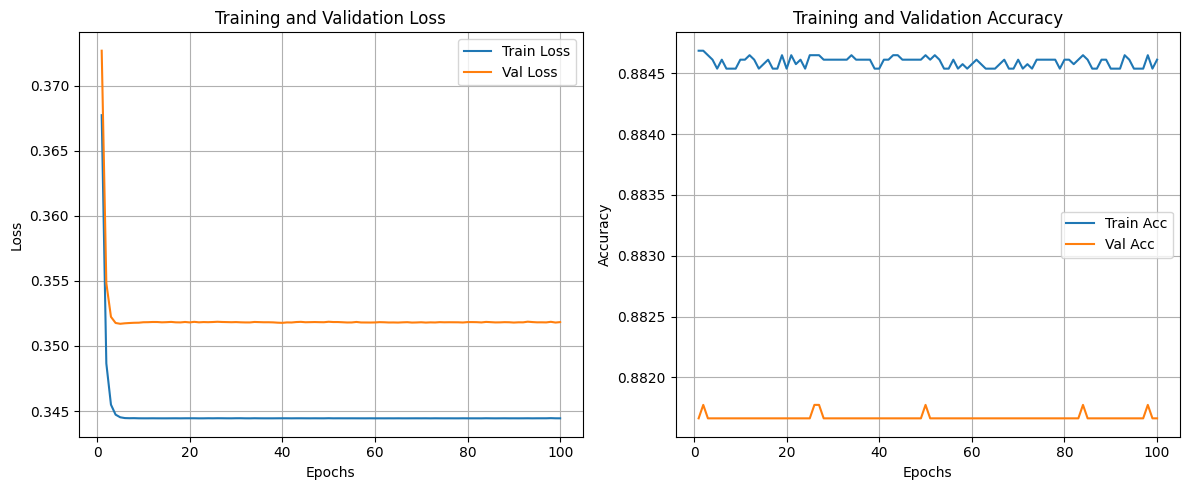

In [23]:
perceptron_torch = PerceptronTorch(dim=X_train.shape[1])
trainer_torch = TrainerTorch(perceptron_torch, n_epochs=100, batch_size=32, lr=0.01)
trainer_torch.train(X_train.values, y_train.values, X_val.values, y_val.values)

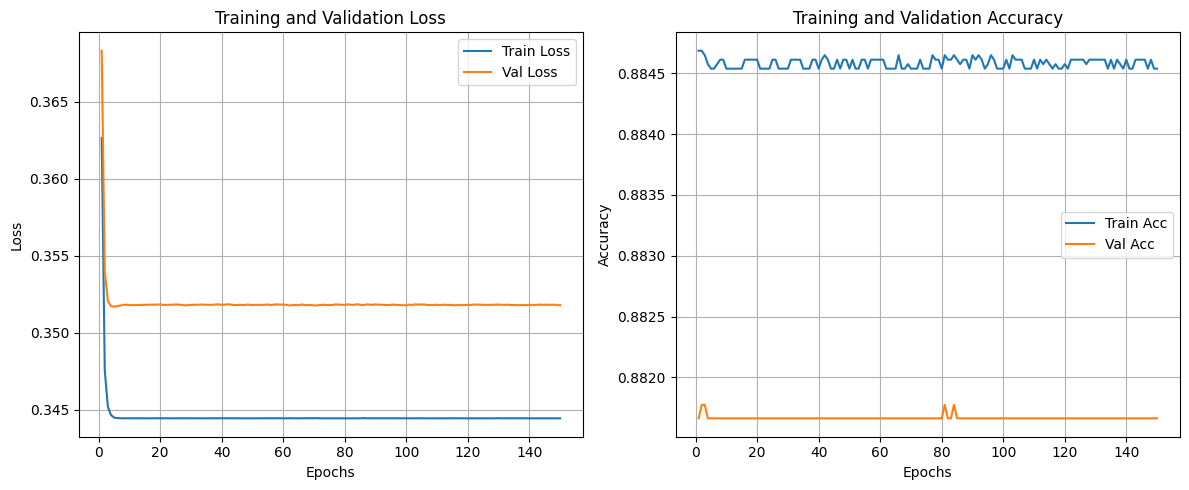

In [24]:
perceptron_torch = PerceptronTorch(dim=X_train.shape[1])
trainer_torch = TrainerTorch(perceptron_torch, n_epochs=150, batch_size=32, lr=0.01)
trainer_torch.train(X_train.values, y_train.values, X_val.values, y_val.values)

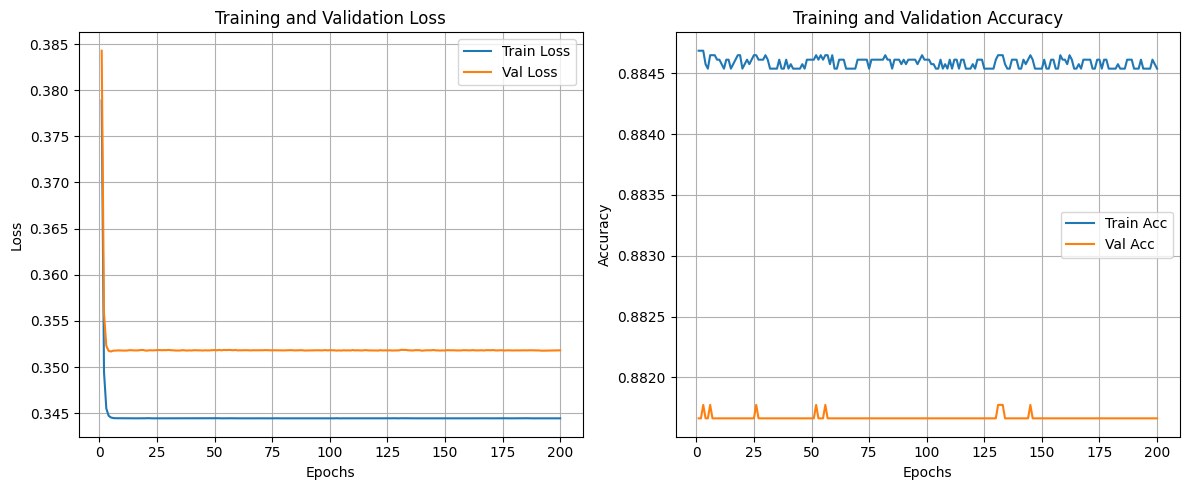

In [25]:
perceptron_torch = PerceptronTorch(dim=X_train.shape[1])
trainer_torch = TrainerTorch(perceptron_torch, n_epochs=200, batch_size=32, lr=0.01)
trainer_torch.train(X_train.values, y_train.values, X_val.values, y_val.values)

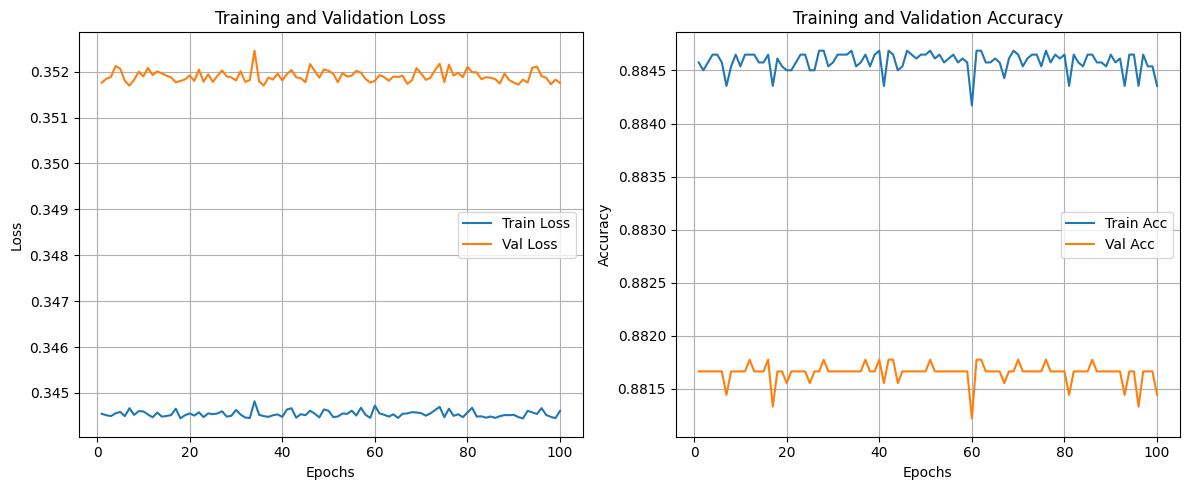

In [26]:
perceptron_torch = PerceptronTorch(dim=X_train.shape[1])
trainer_torch = TrainerTorch(perceptron_torch, n_epochs=100, batch_size=32, lr=0.05)
trainer_torch.train(X_train.values, y_train.values, X_val.values, y_val.values)

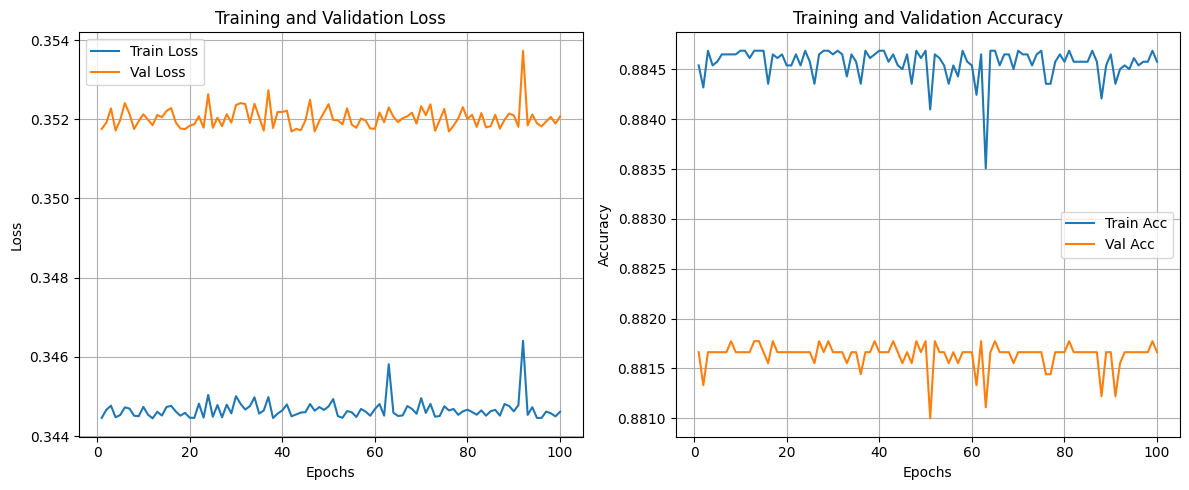

In [27]:
perceptron_torch = PerceptronTorch(dim=X_train.shape[1])
trainer_torch = TrainerTorch(perceptron_torch, n_epochs=100, batch_size=32, lr=0.1)
trainer_torch.train(X_train.values, y_train.values, X_val.values, y_val.values)

Jak widać mamy lekki overfitting, model po ok. 10 epokach się już nie uczy. Pewnie jest to spowodowane zbyt skomplikowanymi danymi.

### Taki smaczek

Perceptron wg. Nano Banana. Co poszło źle?


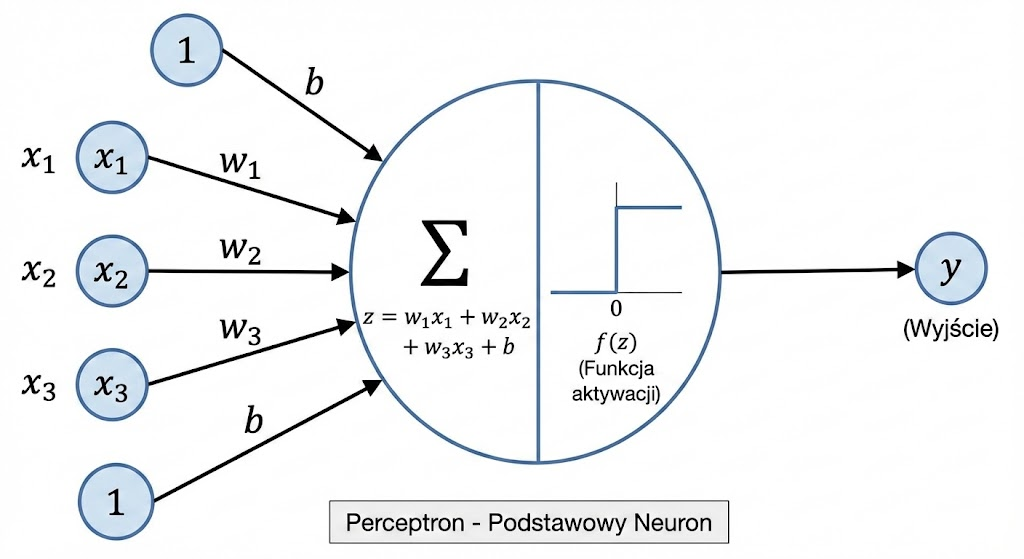